Install Required Libraries

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Tuned Random Forest - MSE: 10.2540, RMSE: 3.2022, MAE: 2.6248, MAPE: 10.52%
Tuned Gradient Boosting - MSE: 10.4523, RMSE: 3.2330, MAE: 2.6507, MAPE: 10.66%
Best model saved as best_model_tuned_random_forest.joblib


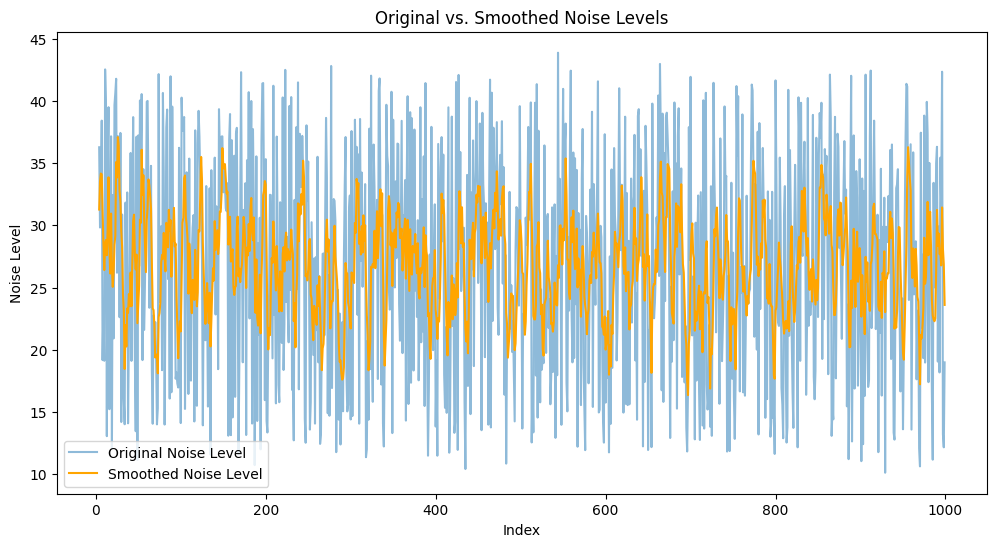

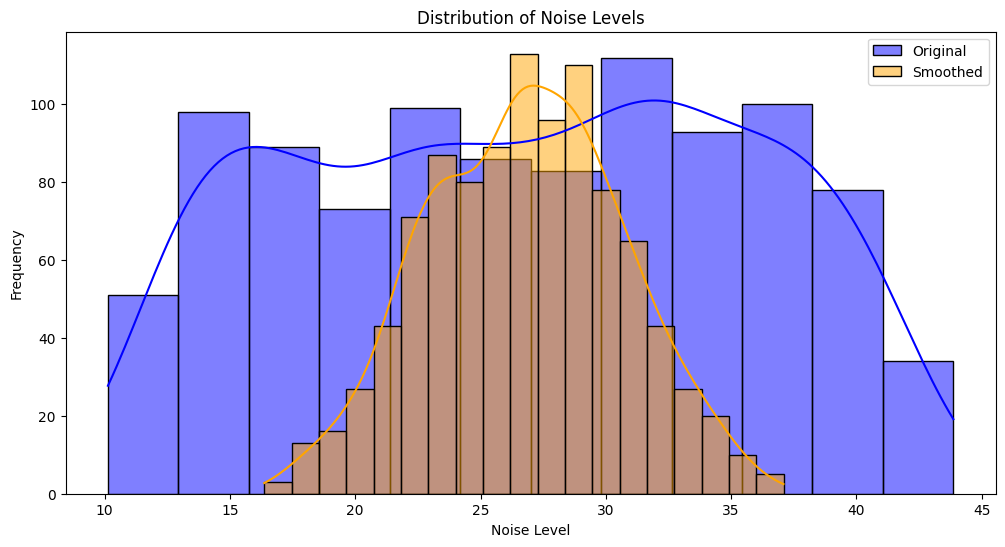

Original Variance: 78.1099
Smoothed Variance: 14.8492


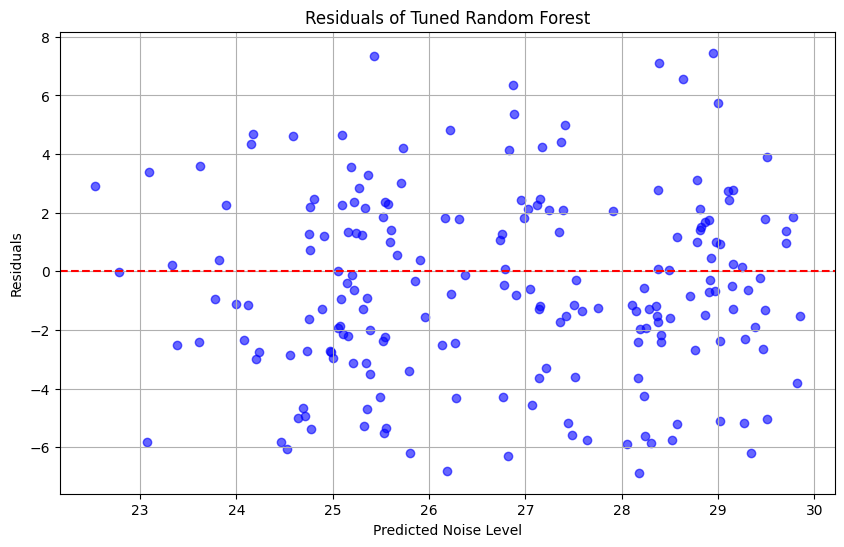

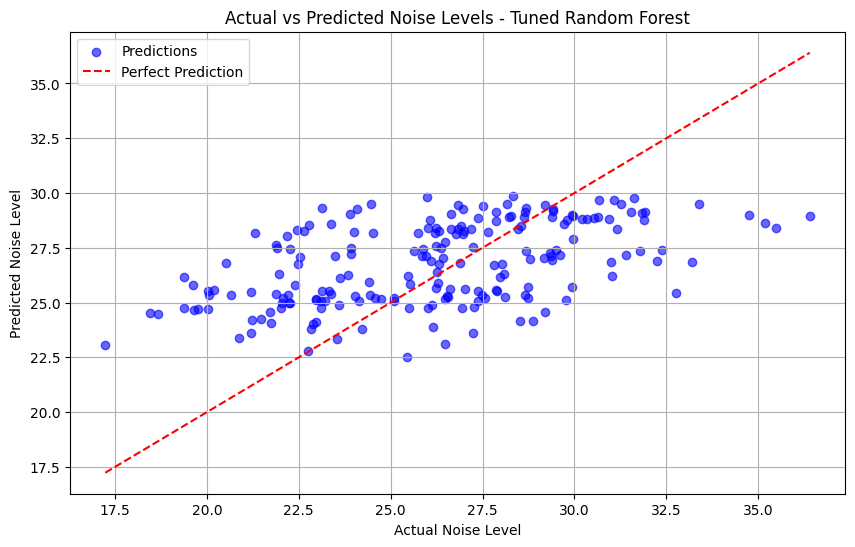

In [73]:
# Install Required Libraries
# !pip install pandas numpy matplotlib seaborn scikit-learn joblib

# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

# Load the Dataset
data = pd.read_csv('cmos_noise_data.csv')

# Data Processing and Noise Reduction
def preprocess_data(data):
    # Drop rows with NaN values
    data = data.dropna()

    # Store original noise levels for comparison
    data['Original_Noise_Level'] = data['Noise_Level']

    # Apply a moving average to smooth the 'Noise_Level' column
    data['Noise_Level'] = data['Noise_Level'].rolling(window=5).mean()

    # Drop NaN values that result from the rolling operation
    data = data.dropna()

    # Separate features and target variable
    X = data.drop('Noise_Level', axis=1)
    y = data['Noise_Level']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, data

X, y, processed_data = preprocess_data(data)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Development
def train_models(X_train, y_train):
    # Hyperparameter grid for Random Forest
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5]
    }

    # Hyperparameter grid for Gradient Boosting
    param_grid_gb = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }

    # Train Random Forest
    rf_model = RandomForestRegressor(random_state=42)
    rf_search = RandomizedSearchCV(rf_model, param_grid_rf, n_iter=5, cv=3, verbose=1, n_jobs=-1, random_state=42)
    rf_search.fit(X_train, y_train)
    best_rf_model = rf_search.best_estimator_

    # Train Gradient Boosting
    gb_model = GradientBoostingRegressor(random_state=42)
    gb_search = RandomizedSearchCV(gb_model, param_grid_gb, n_iter=5, cv=3, verbose=1, n_jobs=-1, random_state=42)
    gb_search.fit(X_train, y_train)
    best_gb_model = gb_search.best_estimator_

    return best_rf_model, best_gb_model

best_rf_model, best_gb_model = train_models(X_train, y_train)

# Model Evaluation
def evaluate_models(models, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100

        results[model_name] = {
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape
        }
        print(f"{model_name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    return results

models = {
    "Tuned Random Forest": best_rf_model,
    "Tuned Gradient Boosting": best_gb_model
}
results = evaluate_models(models, X_test, y_test)

# Save the Best Model
best_model_name = min(results, key=lambda k: results[k]['MAPE (%)'])
best_model = models[best_model_name]
model_filename = f"best_model_{best_model_name.replace(' ', '_').lower()}.joblib"
joblib.dump(best_model, model_filename)
print(f"Best model saved as {model_filename}")

# Visualization of Noise Reduction
def plot_noise_reduction(original_data):
    plt.figure(figsize=(12, 6))
    plt.plot(original_data['Original_Noise_Level'], label='Original Noise Level', alpha=0.5)
    plt.plot(original_data['Noise_Level'], label='Smoothed Noise Level', color='orange')
    plt.title('Original vs. Smoothed Noise Levels')
    plt.xlabel('Index')
    plt.ylabel('Noise Level')
    plt.legend()
    plt.show()

# Plot noise reduction
plot_noise_reduction(processed_data)

# Distribution of Noise Levels
def plot_noise_distribution(data):
    plt.figure(figsize=(12, 6))
    sns.histplot(data['Original_Noise_Level'], kde=True, label='Original', color='blue', alpha=0.5)
    sns.histplot(data['Noise_Level'], kde=True, label='Smoothed', color='orange', alpha=0.5)
    plt.title('Distribution of Noise Levels')
    plt.xlabel('Noise Level')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot noise distribution
plot_noise_distribution(processed_data)

# Variance Comparison
original_variance = np.var(processed_data['Original_Noise_Level'])
smoothed_variance = np.var(processed_data['Noise_Level'])
print(f'Original Variance: {original_variance:.4f}')
print(f'Smoothed Variance: {smoothed_variance:.4f}')

# Residuals Analysis
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, color='blue')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Residuals of {model_name}')
    plt.xlabel('Predicted Noise Level')
    plt.ylabel('Residuals')
    plt.grid()
    plt.show()

# Plot residuals for the best model
y_pred_best = models[best_model_name].predict(X_test)
plot_residuals(y_test, y_pred_best, best_model_name)

# Visualization of Actual vs. Predicted Noise Levels
def plot_noise_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
    plt.title(f'Actual vs Predicted Noise Levels - {model_name}')
    plt.xlabel('Actual Noise Level')
    plt.ylabel('Predicted Noise Level')
    plt.legend()
    plt.grid()
    plt.show()

# Plot for the best model
plot_noise_predictions(y_test, y_pred_best, best_model_name)


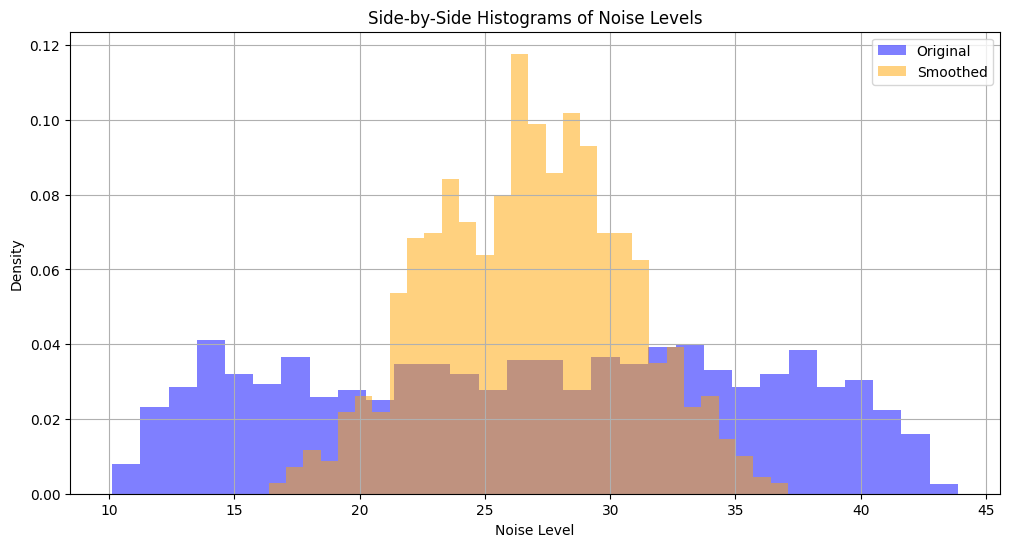

In [74]:
def plot_side_by_side_histograms(original_data):
    plt.figure(figsize=(12, 6))
    plt.hist(original_data['Original_Noise_Level'], bins=30, alpha=0.5, label='Original', color='blue', density=True)
    plt.hist(original_data['Noise_Level'], bins=30, alpha=0.5, label='Smoothed', color='orange', density=True)
    plt.title('Side-by-Side Histograms of Noise Levels')
    plt.xlabel('Noise Level')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

# Plot side-by-side histograms
plot_side_by_side_histograms(processed_data)

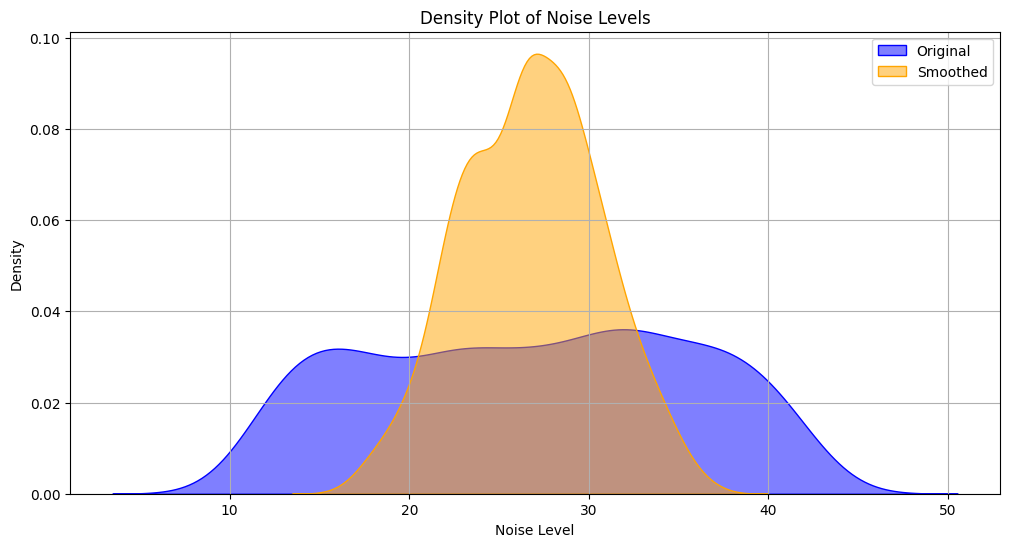

In [75]:
def plot_density(original_data):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(original_data['Original_Noise_Level'], label='Original', color='blue', fill=True, alpha=0.5)
    sns.kdeplot(original_data['Noise_Level'], label='Smoothed', color='orange', fill=True, alpha=0.5)
    plt.title('Density Plot of Noise Levels')
    plt.xlabel('Noise Level')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

# Plot density
plot_density(processed_data)

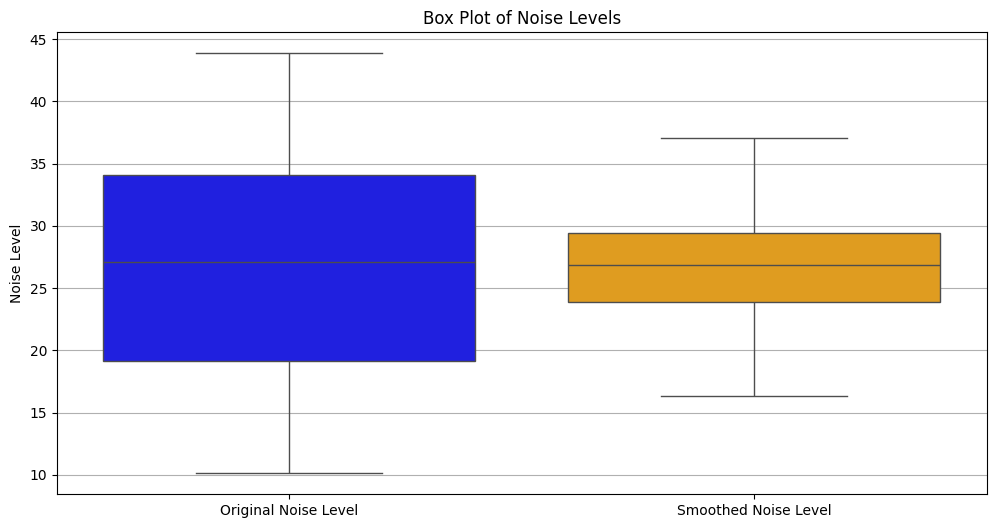

In [77]:
def plot_noise_boxplot(original_data):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=[original_data['Original_Noise_Level'], original_data['Noise_Level']],
                palette=["blue", "orange"])
    plt.xticks([0, 1], ['Original Noise Level', 'Smoothed Noise Level'])
    plt.title('Box Plot of Noise Levels')
    plt.ylabel('Noise Level')
    plt.grid(axis='y')
    plt.show()

# Plot box plot
plot_noise_boxplot(processed_data)